# Noise reduction model training

In [1]:
!git clone https://github.com/karlosos/noise_reduction

Cloning into 'noise_reduction'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 97 (delta 32), reused 79 (delta 20), pack-reused 0
Unpacking objects: 100% (97/97), done.


In [2]:
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend 
import tensorflow as tf

In [3]:
from noise_reduction.model_unet import unet1 as unet

2.5.0


## Download training/testing data from [google drive link](https://drive.google.com/file/d/1-3XTuOUfU_xkgXZJgMrc4QZ_-ElvNrjs/view).

In [4]:
!gdown --id 1-3XTuOUfU_xkgXZJgMrc4QZ_-ElvNrjs

Downloading...
From: https://drive.google.com/uc?id=1-3XTuOUfU_xkgXZJgMrc4QZ_-ElvNrjs
To: /content/development_data.zip
2.86GB [00:39, 32.1MB/s]


In [5]:
!unzip -q development_data.zip

## Loading training data

In [6]:
from scipy import stats

train_path_spectograms = "./data/train/spectogram/"

X_in = np.load(train_path_spectograms + 'noisy_voice_amp_db.npy')
X_ou = np.load(train_path_spectograms + 'voice_amp_db.npy')
X_ou = X_in - X_ou

In [ ]:
print(stats.describe(X_in.reshape(-1,1)))
print(stats.describe(X_ou.reshape(-1,1)))

DescribeResult(nobs=16384000, minmax=(array([-80.]), array([0.])), mean=array([-48.48390411]), variance=array([270.94019037]), skewness=array([0.09251783]), kurtosis=array([-0.36398992]))
DescribeResult(nobs=16384000, minmax=(array([-55.095948]), array([80.])), mean=array([3.63700982]), variance=array([82.0904979]), skewness=array([2.28220794]), kurtosis=array([6.46080001]))


## Scaling data between -1 and 1

In [7]:
# Scale data between -1 and 1
X_in = (X_in + 46)/50
X_ou = (X_ou -6 )/82

print(X_in.shape)

print(stats.describe(X_in.reshape(-1,1)))
print(stats.describe(X_ou.reshape(-1,1)))

(1000, 128, 128)
DescribeResult(nobs=16384000, minmax=(array([-0.68]), array([0.92])), mean=array([-0.04967808]), variance=array([0.10837608]), skewness=array([0.09251783]), kurtosis=array([-0.36398992]))
DescribeResult(nobs=16384000, minmax=(array([-0.74507254]), array([0.90243902])), mean=array([-0.02881695]), variance=array([0.01220858]), skewness=array([2.28220794]), kurtosis=array([6.46080001]))


In [8]:
print(X_in.shape,X_ou.shape)

(1000, 128, 128) (1000, 128, 128)


## Reshape data for training and create test set for development

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Reshape for training
X_in = X_in[:,:,:]
X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)
X_ou = X_ou[:,:,:]
X_ou = X_ou.reshape(X_ou.shape[0],X_ou.shape[1],X_ou.shape[2],1)

X_train, X_test, y_train, y_test = train_test_split(X_in, X_ou, test_size=0.10, random_state=42)

## Create generator

In [10]:
pretrained_weights = False

if pretrained_weights:
  # If training from pre-trained weights
  generator_nn=unet(pretrained_weights = root_path+'mod_unet_last_weights.h5')
else:
  #If training from scratch
  generator_nn=unet()

#Save best models to disk
checkpoint = ModelCheckpoint('./model/model-{epoch:03d}-{loss:03f}-{val_loss:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

generator_nn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        leaky_re_lu[0][0]                
______________________________________________________________________________________________

## Training

In [21]:
history = generator_nn.fit(X_train, y_train, epochs=50, batch_size=40, shuffle=True, callbacks=[checkpoint], verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
23/23 [==============================] - 6s 156ms/step - loss: 0.0023 - mae: 0.0415 - val_loss: 0.0047 - val_mae: 0.0620

Epoch 00001: val_loss did not improve from 0.00375
Epoch 2/50
23/23 [==============================] - 4s 155ms/step - loss: 0.0023 - mae: 0.0416 - val_loss: 0.0047 - val_mae: 0.0607

Epoch 00002: val_loss did not improve from 0.00375
Epoch 3/50
23/23 [==============================] - 4s 156ms/step - loss: 0.0023 - mae: 0.0414 - val_loss: 0.0041 - val_mae: 0.0563

Epoch 00003: val_loss did not improve from 0.00375
Epoch 4/50
23/23 [==============================] - 4s 157ms/step - loss: 0.0024 - mae: 0.0420 - val_loss: 0.0052 - val_mae: 0.0626

Epoch 00004: val_loss did not improve from 0.00375
Epoch 5/50
23/23 [==============================] - 4s 157ms/step - loss: 0.0023 - mae: 0.0411 - val_loss: 0.0045 - val_mae: 0.0615

Epoch 00005: val_loss did not improve from 0.00375
Epoch 6/50
23/23 [==============================] - 4s 158ms/step - loss: 0.0022

## Plot training progress

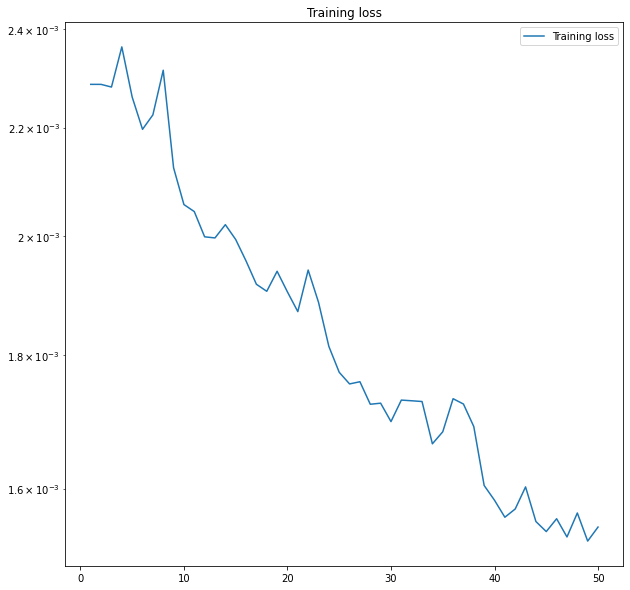

In [24]:
from matplotlib import pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

fig = plt.figure(figsize=(10, 10))
plt.plot(epochs, loss, label='Training loss')
plt.yscale('log')
plt.title('Training loss')
plt.legend()
plt.show()

## Testing model

In [25]:
# Predict and QC the output
X_pred_test = generator_nn.predict(X_test)

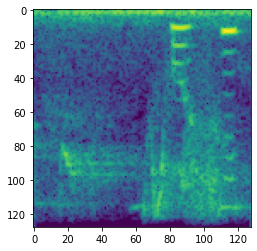

In [26]:
import matplotlib.pyplot as plt

id = 30
plt.imshow(X_test[id,:,:,0])

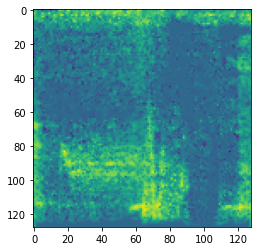

In [27]:
plt.imshow(y_test[id,:,:,0])

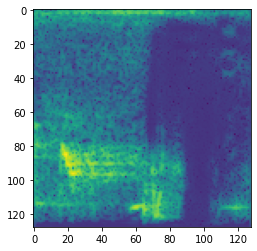

In [28]:
plt.imshow(X_pred_test[id,:,:,0])

## Save weights to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/app/'

In [ ]:
#Save last model to disk
model_json = generator_nn.to_json()
with open("/content/gdrive/My Drive/app/mod_unet_last_weights.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
generator_nn.save_weights("/content/gdrive/My Drive/app/mod_unet_last_weights.h5")
print("Saved model to disk")

Saved model to disk
